# Introduction
This is the random forest learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [50]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# DETERMINE IF YOU ARE USING RAW OR SCALED
Scaled is Zhao's data, continuous variables divided by standard deviation
<br>Raw is unscaled raw data

In [51]:
useRaw=True

In [3]:
#get the data
if (useRaw == True):
    df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")
else:
    df = pd.read_csv('./data/ccesplus_fscaled.csv',encoding = "ISO-8859-1")

# Load train/test
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [52]:
os.makedirs('tmp', exist_ok=True)

trnfile = 'tmp/train_regid31'
tstfile = 'tmp/tst_regid31'
jsonfile = 'tmp/catcont_regid3.json'

if (useRaw == True):
    trnfile = 'tmp/train_regid31_raw'
    tstfile = 'tmp/tst_regid31_raw'
    jsonfile = 'tmp/catcont_regid31_raw.json'

In [53]:
#get processed training and test data
trn_raw = pd.read_feather(trnfile)
tst_raw = pd.read_feather(tstfile)

trn = trn_raw.copy()
tst = tst_raw.copy()

# columns_dep_var= 'cc.vote16'

In [54]:
#get continuous and categorical variables
with open(jsonfile) as f:
    data1 = json.load(f)
    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2][0]
   
# res_cont
# res_cat

In [55]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [56]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

57888
6432


## Lets see what features are corelated with each other

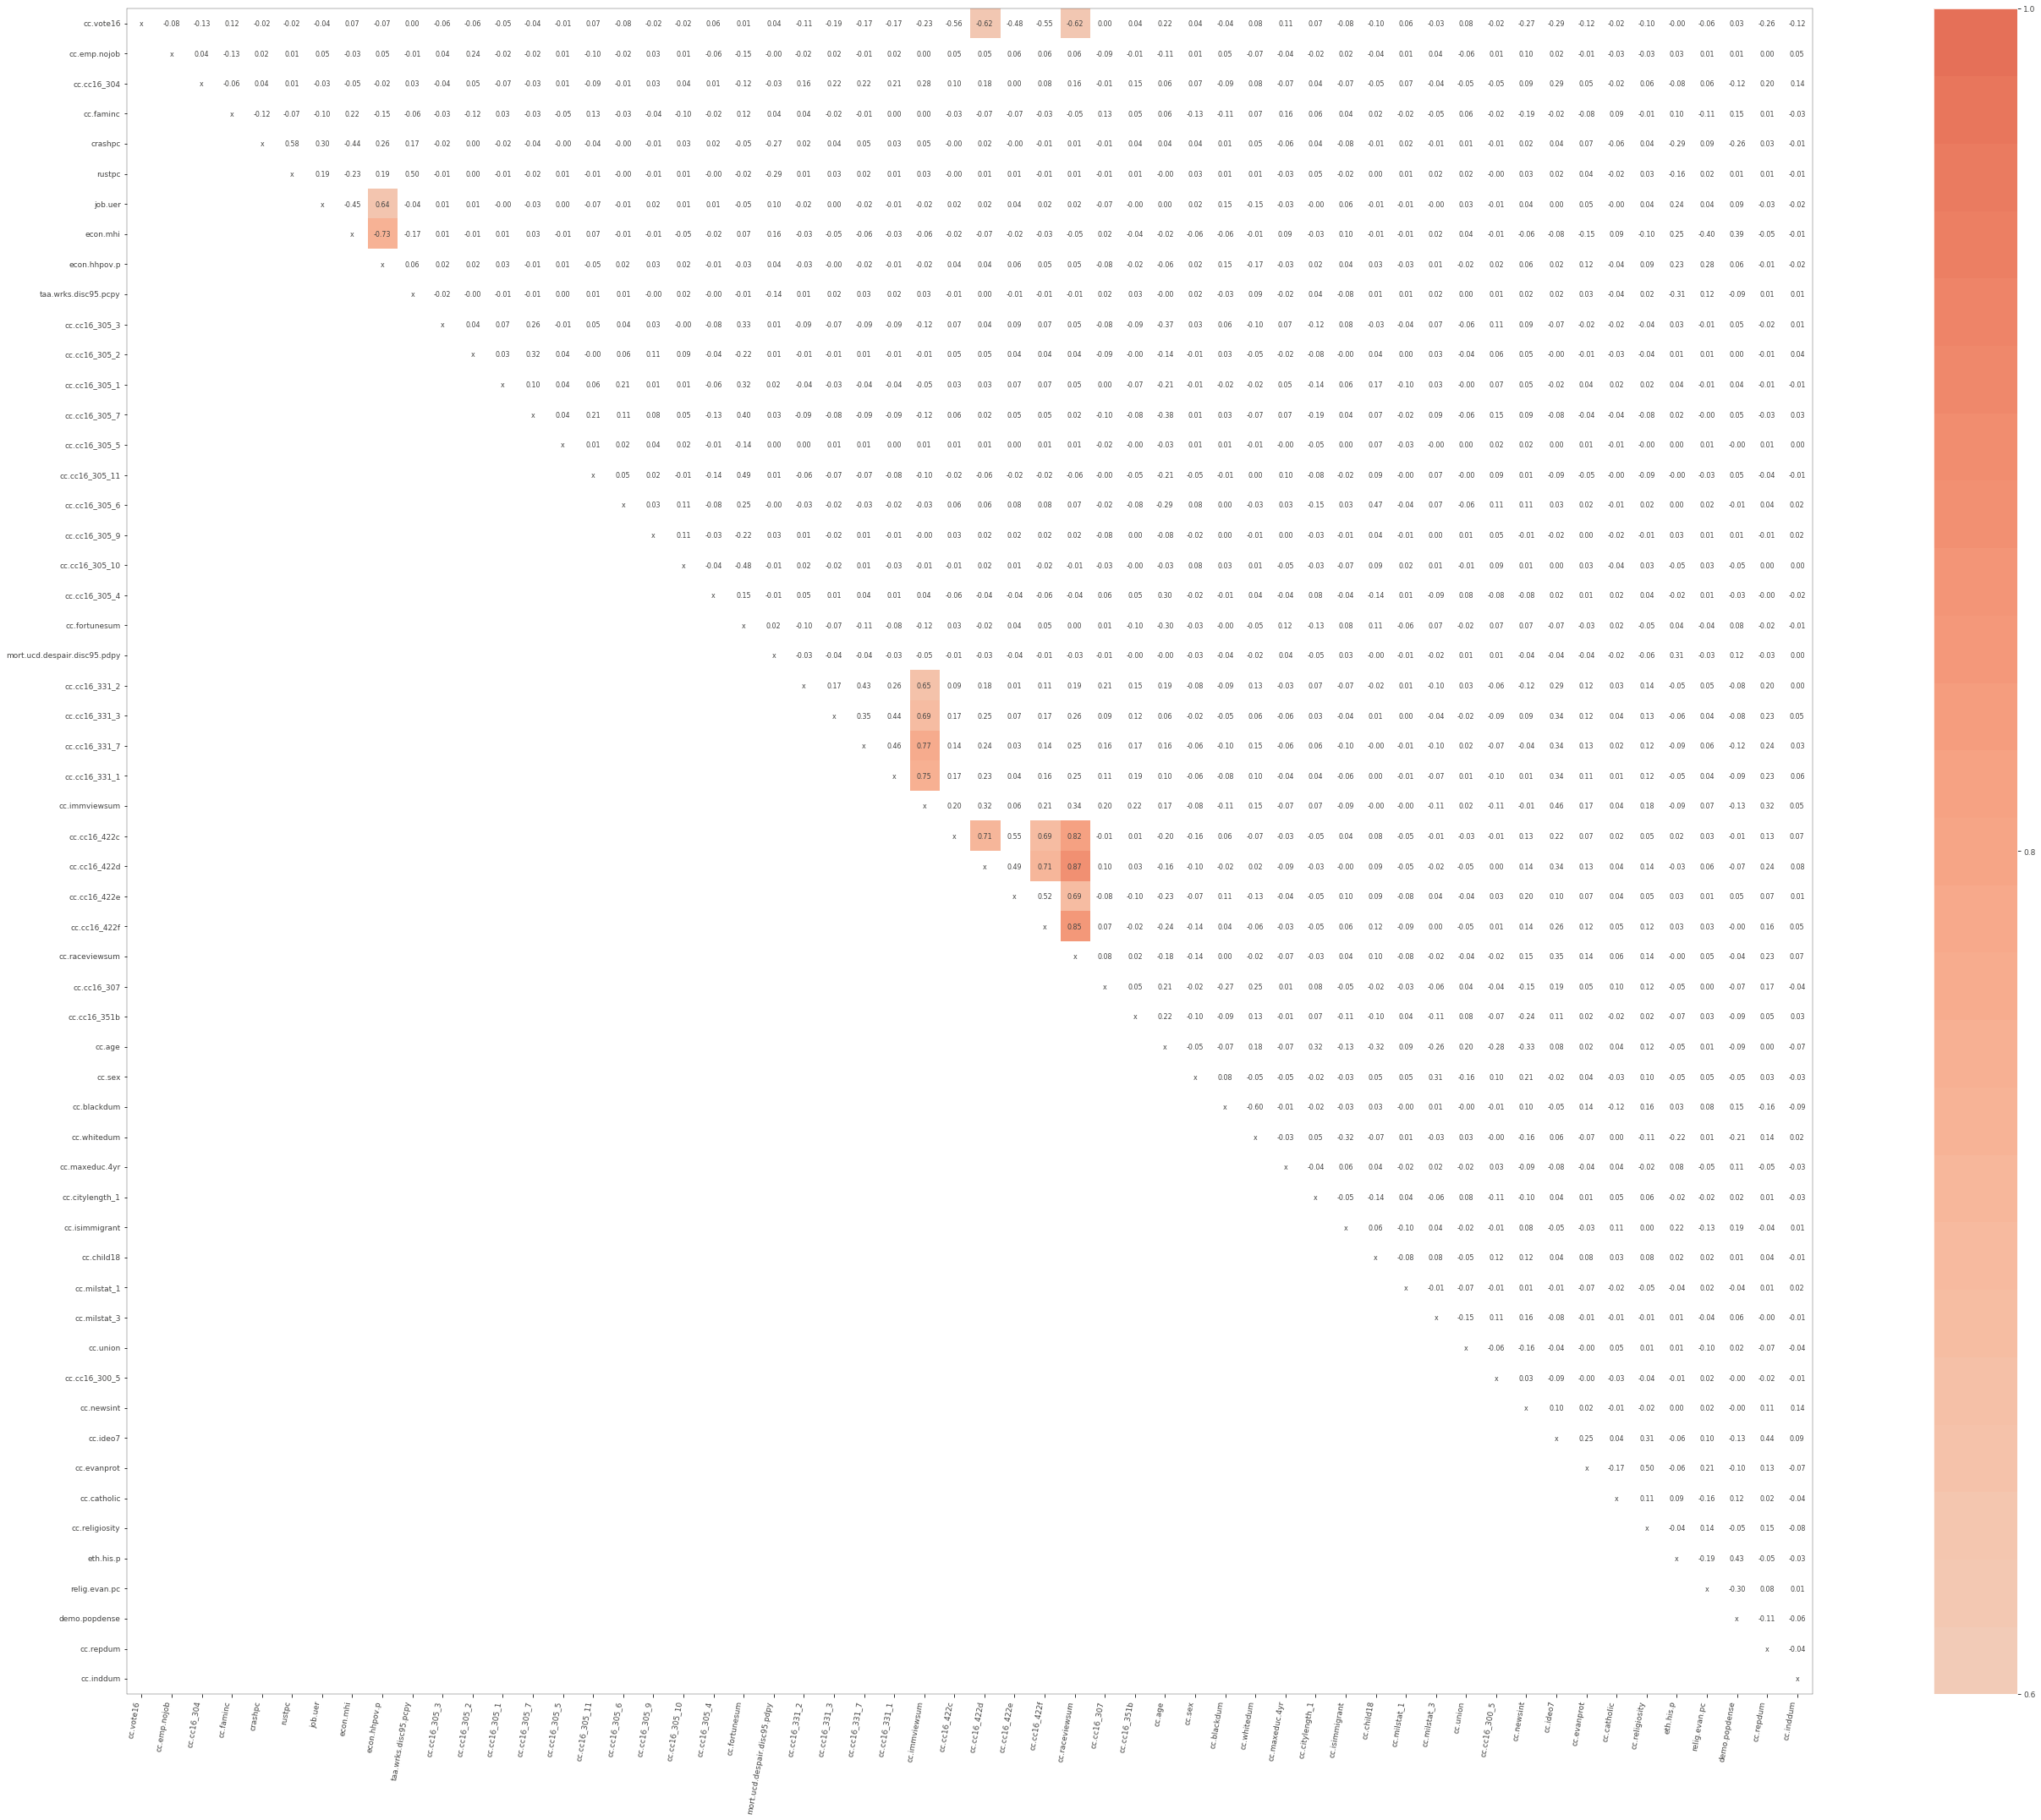

In [57]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(trn, figsize=(50,30))
viz.view()

## Categorify and Fill Missing

In [59]:
#from docs https://docs.fast.ai/tabular.transform.html
tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
tfm(trn)
tfm(tst)

In [60]:
#just checking to see if it works on any old variable
trn[res_cat[0]].cat.categories
tst[res_cat[0]].cat.categories

Int64Index([0, 1], dtype='int64')

Int64Index([0, 1], dtype='int64')

In [61]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [62]:
trn_y=trn[columns_dep_var].copy()
trn=trn.drop(columns_dep_var,axis=1)

tst_y=tst[columns_dep_var].copy()
tst=tst.drop(columns_dep_var,axis=1)

# trn.T
# trn_y

In [63]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 55, total tst columns = 55
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [64]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

#find the index of the column in trn
# idx=trn.columns.tolist().index('cc.catholic_na')
# idx
# type(trn.columns)

# tst.insert(loc=idx, column='cc.catholic_na', value=False)

set()

set()

# Train a RandomForest on all data

In [65]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#create a random forest object
m_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=10)

In [66]:

def rmse(x,y): 
    '''this and R**2 used for continuous variables'''
    return math.sqrt(((x-y)**2).mean())

def print_score(m, trn, trn_y, tst, tst_y):
    '''
    
    '''
    res = [m.score(trn, trn_y), m.score(tst, tst_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [67]:
#train the random forest 
m_rf.fit(trn, trn_y)

print_score(m_rf, trn, trn_y, tst, tst_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

[0.8262852404643449, 0.785136815920398, 0.7802998894416805]


# Test the model on test data

In [68]:
def eval_accuracy(preds,targs, silent=True):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    acc=100*matches/totals 
    if( silent == False):
        print(f"Got {matches} right out of {totals} samples, Accuracy is {acc} percent")
    return acc

In [70]:
preds1 = m_rf.predict(tst)

eval_accuracy(preds1,tst_y,silent=False);

Got 5050 right out of 6432 samples, Accuracy is 78.5136815920398 percent


# Which features are important
How is the model making predictions?  What matters?  What features give the most information gain?

Use this information to select only relevant features to train the model on, this simplifies the model while preserving accuracy.  And simplicity tends toward better generalization.

## Lets try default Feature importance (flawed scikitlrn implementation)

In [71]:
#copied from fastai structured.py
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [72]:
#lets figure out whats most important (top 20 out of 32)
fi = rf_feat_importance(m_rf, tst);

fi['imp'].sum() #should be 1
fi[:20];

<B>Run section 6 with just the to_keep columns</B>

## Lets try random permutation based feature importance
Should be more accurate but is computationally expensive see <a href="https://explained.ai/rf-importance/index.html#5">Beware Default Random Forest Importances</a>

In [73]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from rfpimp import permutation_importances, oob_classifier_accuracy

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

def acc(rf, X_train, y_train):
    return accuracy_score(y_train, rf.predict(X_train))

trn_pb=trn.copy()
trn_pb_y=trn_y.copy()

In [74]:
#the following calculates how each feature affects the result
#First it gets the baseline metric (acc) for the entire set  (trn_pb, trn_pb_y)
#then it permutes a single feature (randomly scrambling that column)
#then calculates the metric (acc) for the entire set (trn_pb, trn_pb_y)
#then it subtracts that from the baseline to see how that metric affects the predictions

feature_importance = permutation_importances(m_rf, trn_pb, trn_pb_y, oob_classifier_accuracy)
# feature_importance_tst = permutation_importances(m_rf, tst.copy(), tst_y.copy(), acc)

The following importance values will not sum up to one, it's important to remember that we don't care what the values are per se. What we care about is the relative predictive strengths of the features. (excerpt from <a href="https://explained.ai/rf-importance/index.html#5">Beware Default Random Forest Importances</a>)

In [75]:
perm_imp_rfpimp = feature_importance.copy().reset_index()

In [76]:
# perm_imp_rfpimp_tst = feature_importance_tst.copy().reset_index()
# # perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
# perm_imp_rfpimp_tst[:30].plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

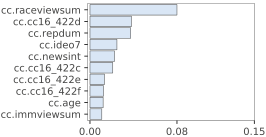

In [77]:
#just another way to plot above (uses OOB)
from rfpimp import plot_importances
plot_importances(feature_importance[:10])
# perm_imp_rfpimp

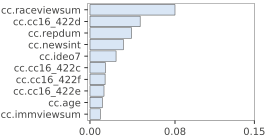

In [78]:
#same as permutation_importances except uses validation set, much, much faster since no loop
from rfpimp import importances
ret = importances(m_rf, trn, trn_y, features=None, n_samples=5000, sort=True, metric=None, sample_weights = None)
plot_importances(ret[:10])

If we have slightly different importances on the training and test sets, this may indicate that the test set and training set may be statisticaly dissimilar

<B>Run section 6 with just the to_keep columns</B>

## Lets try a different library (eli5) random permutation based feature importance
Should be more accurate but is computationally expensive see 

In [79]:
from eli5.sklearn import PermutationImportance
# m2= RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=10)

%time perm = PermutationImportance(m_rf).fit(tst,tst_y)

CPU times: user 2min 28s, sys: 4.83 s, total: 2min 33s
Wall time: 49.8 s


## Try dropcol_importances
train a model over and over, dropping 1 column at a time 

In [80]:
from rfpimp import dropcol_importances

mrf_dc = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            oob_score=True, max_features='auto', min_samples_leaf=10)
mrf_dc.fit(trn, trn_y)

#this will take a while
feature_importanceDC = dropcol_importances(mrf_dc, trn, trn_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [81]:
feature_importanceDC1 = feature_importanceDC.copy().reset_index()

## Show graphs for above methods

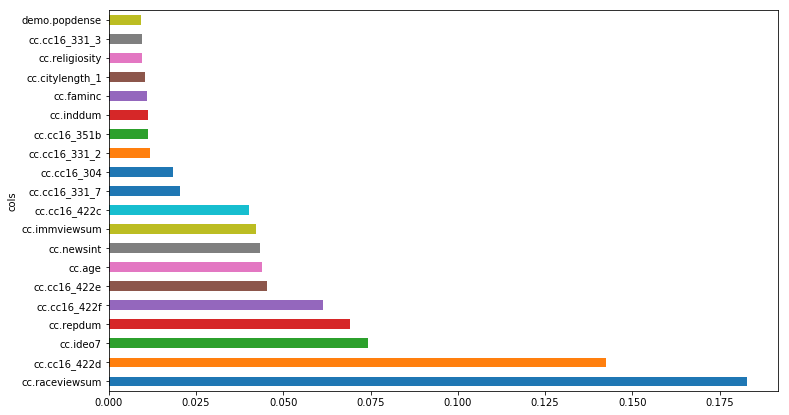

In [82]:
#plot the top 20 for sklearn feature importance based on Gini info gain
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:20]);
# plot_fi(fi[40:]);

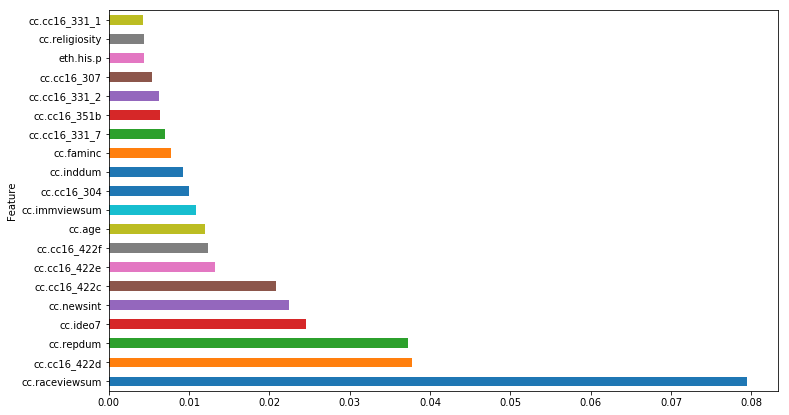

In [83]:
#for column permutations
# perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
perm_imp_rfpimp[:20].plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

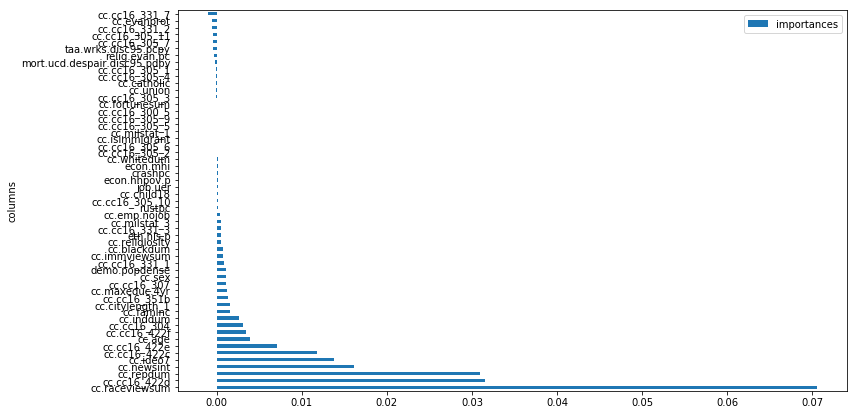

In [93]:
I = pd.DataFrame(data={"columns":tst.columns, "importances":perm.feature_importances_})
I = I.set_index("columns")
I = I.sort_values('importances', ascending=False)
# I
I[:20].plot.barh(figsize=(12,7))
# I[:20].plot(x='columns',y='importances',kind= 'barh', figsize=(12,7), legend=False)

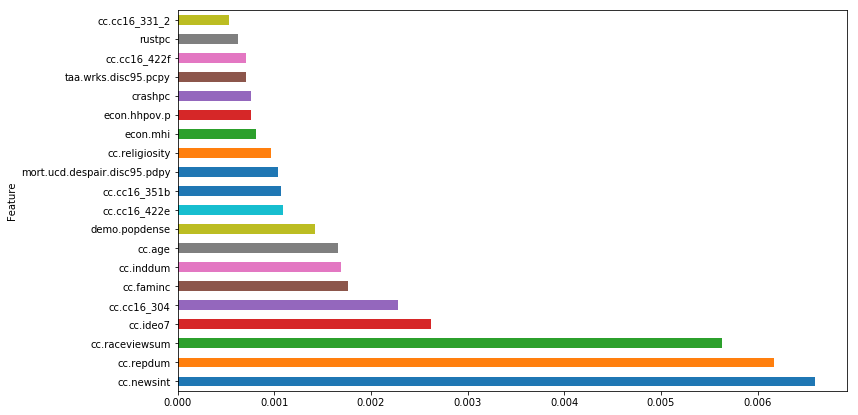

In [85]:
#for drop column, if negative you can drop that single column and the model will improve, but that does not mean you can drop all
#of them
# perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
feature_importanceDC1[:20].plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

# Train a new RandomForest only on important features (drop others)

In [86]:
def rerunWithFewerColumns(to_keep, silent=True):
    if(silent ==False):
        print(f"number of features we are running on={len(to_keep)}")
        
    #create new trn set, keep only columns listed above
    trn_keep = trn[to_keep].copy()
    tst_keep =tst[to_keep].copy()

    m1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            oob_score=True, max_features='auto', min_samples_leaf=10)
    m1.random_state=999 #ensures consistency
    m1.fit(trn_keep, trn_y)

    if(silent ==False):
        print_score(m1, trn_keep, trn_y, tst_keep, tst_y )
    
    preds1 = m1.predict(tst_keep)
    return eval_accuracy(preds1,tst_y, silent)

In [87]:
def getResults(to_keep_SK,to_keep_RF, to_keep_eli5, to_keep_DC, silent=True):
    if(silent ==False):
        print("for sklearn implementation of feature importance:")
    ac1 = rerunWithFewerColumns(to_keep_SK,silent)

    if(silent ==False):
        print("\nfor rfpimp implementation of feature importance:")
    ac2=rerunWithFewerColumns(to_keep_RF, silent)
    
    if(silent ==False):
        print("\nfor eli5 implementation of permuted feature importance:")
    ac3=rerunWithFewerColumns(to_keep_eli5, silent)

    if(silent ==False):
        print("\nfor rfpimp implementation of drop column feature importance:")
    ac4=rerunWithFewerColumns(to_keep_DC, silent)
    
    return ac1,ac2,ac3,ac4
        

In [88]:
#lets get the most important columns from sk, RF and DC
# to_keep_SK=fi[fi.imp>0.008].cols; len(to_keep_SK)
to_keep_SK=fi[:].cols.reset_index(drop=True); len(to_keep_SK)

#keep the same number as above in sklearn feature importance implementation
# to_keep_RF = perm_imp_rfpimp[perm_imp_rfpimp['Importance']>.000].Feature;len(to_keep_RF)
# to_keep_RF = perm_imp_rfpimp[:len(to_keep_SK)].Feature;len(to_keep_RF)
to_keep_RF = perm_imp_rfpimp[:].Feature;len(to_keep_RF)

to_keep_eli5P = I[:].reset_index()['columns'];len(to_keep_eli5P)

# to_keep_DC = feature_importanceDC1[:len(to_keep_SK)].Feature;len(to_keep_DC)
to_keep_DC = feature_importanceDC1[:].Feature;len(to_keep_DC)
# to_keep_DC = feature_importanceDC1[feature_importanceDC1['Importance']>.000].Feature;len(to_keep_DC)

55

55

55

55

In [89]:
#test removing 1 column at a time, most important first, to see how model performs
res = []
orig_size = len(to_keep_SK)
print(f"Dropping feature.",end=' ')
for _ in range(len(to_keep_SK)-1):
    print(f" {orig_size-len(to_keep_SK)}",end=".")
    res.append(getResults(to_keep_SK,to_keep_RF,to_keep_eli5P,to_keep_DC))

    to_keep_SK.drop(to_keep_SK.index[0], inplace = True)
    to_keep_RF.drop(to_keep_RF.index[0], inplace = True)
    to_keep_eli5P.drop(to_keep_eli5P.index[0], inplace = True)
    to_keep_DC.drop(to_keep_DC.index[0], inplace = True)

Dropping feature.  0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Features dropped (starting with most important')

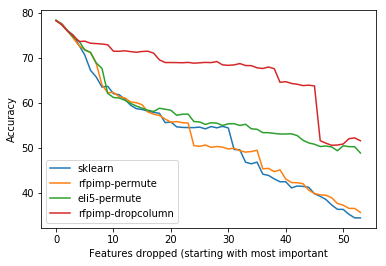

In [90]:
plt=None
import matplotlib.pyplot as plt
plt.plot(res)
plt.ylabel("Accuracy")
plt.xlabel('Features dropped (starting with most important')
plt.gca().legend(('sklearn','rfpimp-permute','eli5-permute','rfpimp-dropcolumn'))
plt.show()

If the feature importance vector is correct then you should have the largest drops in accuracy in the begginning with a leveling off effect as more (and less important) features) are dropped.  eli5-permute is the only one exhibiting that behaviour.<br>
On the other hand there is something definitely wrong with rfpimp-dropcolumn, it has a low drop until it hits a cliff later<br>
This can all be due to multi collinearity, you keep dropping correlated columns, but the remaining ones take up the slack. That is until the last one is dropped, then you get a cliff.
<br><B> Takeaway: eli5 is a solid product. rfpimp is not (it states that its a learning excercise in the docs)</b>

In [92]:
# Wanna see diffs between columns?
# print("diff between last 2")
# set(to_keep_RF)-set(to_keep_DC)

# set(to_keep_DC)-set(to_keep_RF)

# So lets run some predictions with eli5 permutations
just keep the important columns

In [98]:
#first with all columns
to_keep = I[:].reset_index()['columns'];len(to_keep)
rerunWithFewerColumns(to_keep,silent=False)

55

number of features we are running on=55
[0.8270280541735766, 0.7838930348258707, 0.7781750967385296]
Got 5042 right out of 6432 samples, Accuracy is 78.38930348258707 percent


78.38930348258707

In [99]:
#now with only the columns that matter
to_keep = I[I.importances>0.0].reset_index()['columns'];len(to_keep_eli5P)
rerunWithFewerColumns(to_keep,silent=False)

37

number of features we are running on=37
[0.8252487562189055, 0.7898009950248757, 0.7817855168601437]
Got 5080 right out of 6432 samples, Accuracy is 78.98009950248756 percent


78.98009950248756

<B>So accuracy goes up if you drop columns that dont matter much.  

# Remove redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. You should be able to remove these correlated features without degrading the OOB score (or R**2 or accuracy) of the model.  In fact the model is simpler so its performence may go up.

The following dendrogram using spearman ranked correlation to get correlations between features.  Start from the right and see which features combine, those are closer together in rank than those not on that fork.  For an excellent overview see <a href="https://www.statisticshowto.datasciencecentral.com/hierarchical-clustering/"> Hierarchical Clustering / Dendrogram</a></strong>

In [100]:
from scipy.cluster import hierarchy as hc

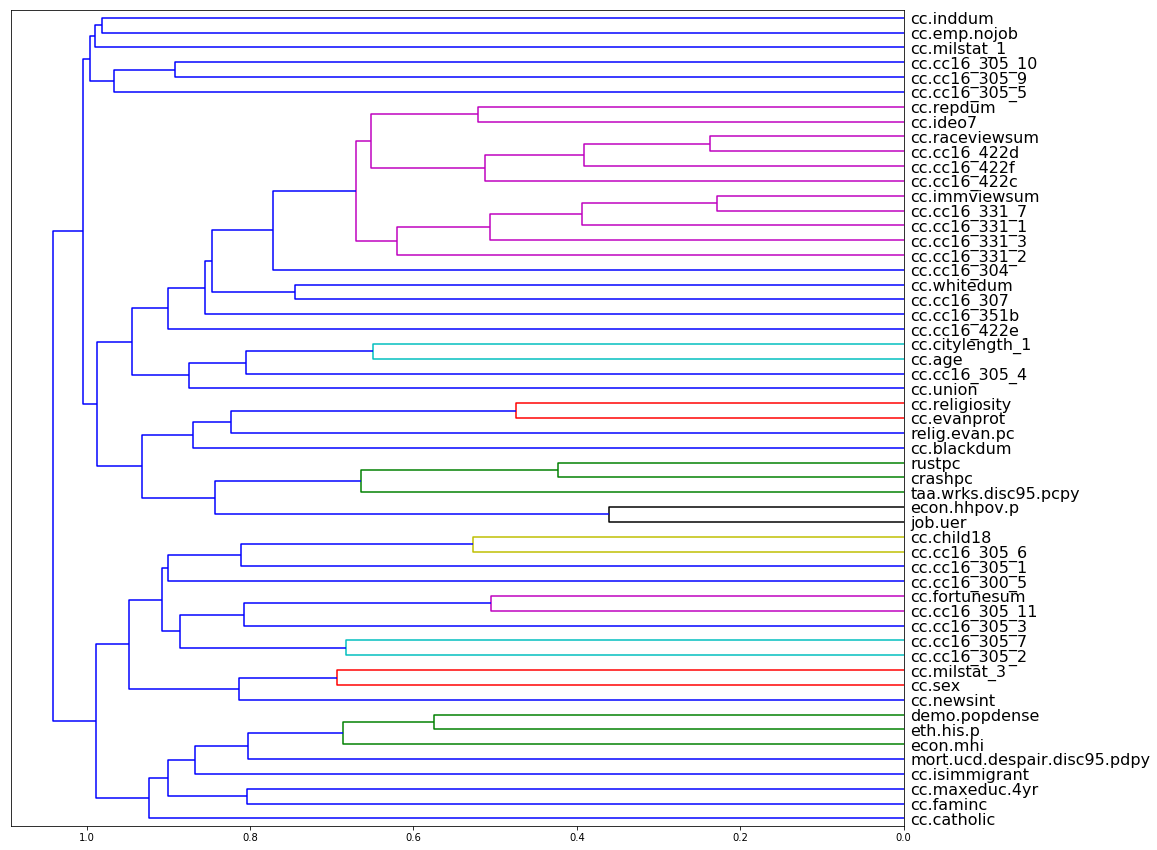

In [101]:
corr = np.round(scipy.stats.spearmanr(trn).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=trn.columns, orientation='left', leaf_font_size=16)
plt.show()

Notice the x axis starts at 1 and goes to 0.  If 2 features are linked at or near 0 then they are highly correlated.  

In [103]:
def get_oob(df,y):
    m= RandomForestClassifier(n_estimators=100,  min_samples_leaf=10, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

#get unaltered score
get_oob(trn, trn_y)

0.7850849917081261

Hmmm... Not much savings here.  

# Partial Dependence

In [104]:
from pdpbox import pdp
from plotnine import *

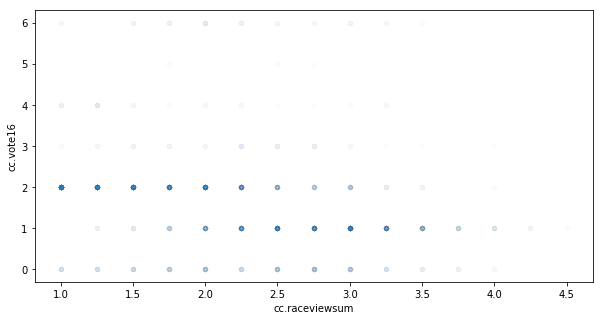

In [107]:
#looks like cc.raceviewsum matters a lot, lets plot it against dependent var
trn_raw[:2000].plot('cc.raceviewsum', columns_dep_var,kind='scatter', alpha=0.01, figsize=(10,5));

In [108]:
import matplotlib.font_manager
def plot_pdp(feat, m, x, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)


In [ ]:
plot_pdp('cc.raceviewsum', m_rf, trn[:500])
plot_pdp('cc.cc16_422d', m_rf, trn[:500])
plot_pdp('cc.ideo7', m_rf, trn[:500])
plot_pdp('cc.cc16_422f', m_rf, trn[:500])
plot_pdp('cc.repdum', m_rf, trn[:500])
plot_pdp('cc.immviewsum', m_rf, trn[:500])
plot_pdp('cc.blackdum', m_rf, trn[:500])   #this is a bool, only 2 values so pdp should be linear

In [ ]:
feats=['cc.ideo7','cc.raceviewsum']
p=pdp.pdp_interact(m_rf, trn, feats)
pdp.pdp_interact_plot(p, feats)

# Conclusions and Next Steps
This model is 78% accurate with no data tweaks

# Scratch

In [ ]:
data = test[0]
data[31]
type(data)
data.shape
tmp=learn.predict(data)
len(tmp)
out,pred,res=tmp

out
pred
res

# len(out)
# len(pred)
len(res)